# 1. Imports

In [1]:
import os
import numpy as np
import pandas as pd
import imageio

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

import matplotlib.pyplot as plt
%matplotlib inline

# 2. Load data

In [2]:
# image_path = '../data/people_segmentation/images'
# mask_path = '../data/people_segmentation/masks'

image_path = '../input/person-segmentation/people_segmentation/images'
mask_path = '../input/person-segmentation/people_segmentation/masks'

image_list = sorted(os.listdir(image_path))  # images are not sorted
mask_list = sorted(os.listdir(mask_path))
image_list = [image_path + "/" + i for i in image_list]
mask_list = [mask_path + "/" + i for i in mask_list]
print(image_list[0])
print(mask_list[0])

../input/person-segmentation/people_segmentation/images/IMG_3496bfree.jpg
../input/person-segmentation/people_segmentation/masks/IMG_3496bfree.png


Text(0.5, 1.0, 'Segmentation')

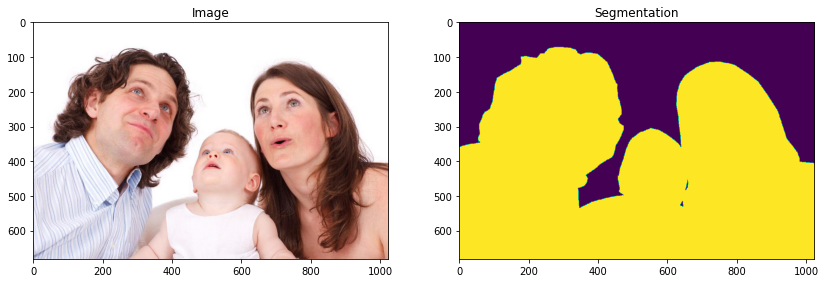

In [3]:
N = 15
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

## Split data into masked and unmasked images

In [4]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'../input/person-segmentation/people_segmentation/images/IMG_3496bfree.jpg', shape=(), dtype=string)
tf.Tensor(b'../input/person-segmentation/people_segmentation/masks/IMG_3496bfree.png', shape=(), dtype=string)


2022-02-22 04:58:37.501406: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Image Preprocessing
I will transform images and masks to tensor and then resizing to a smaller size to speed up computation.

In [5]:
IMAGE_SIZE = (192, 256)

def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3) / 255  # since it is a jpg file
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)  # by default has 2 dimensions with 0's and 1's
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, IMAGE_SIZE, method='nearest')
    input_mask = tf.image.resize(mask, IMAGE_SIZE, method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)
processed_image_ds

<MapDataset shapes: ((192, 256, 3), (192, 256, 3)), types: (tf.float32, tf.float32)>

# 3. U-Net Architecture
## Encoder (Convolutional Blocks)

In [6]:
def encoder_block(inputs=None, n_filters=32, dropout=0, max_pooling=True):
    """
    Convolutional encoder block
    
    Parameters
    ----------
    inputs: tensor
        Input tensor
    n_filters: int 
        Number of convolutional layer channels
    dropout: float
        Dropout probability between 0 and 1
    max_pooling: bool
        Whether to MaxPooling2D for spatial dimensions reduction
        
    Returns
    -------
    next_layer, skip_connection
        Next layer for the downsampling section and skip connection outputs
    """

    conv = Conv2D(filters=n_filters, 
                  kernel_size=3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(filters=n_filters, 
                  kernel_size=3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    # Add dropout if existing
    if dropout > 0:
        conv = Dropout(dropout)(conv)
         
        
    # Add MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
    
    skip_connection = conv  # excluding maxpool from skip connection
    
    return next_layer, skip_connection

## Decoder (Upsampling) Blocks

In [7]:
def decoder_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional decoder block
    
    Parameters
    ----------
    expansive_input: tensor
        Input tensor
    contractive_input: tensor
        Input tensor from matching encoder skip layer
    n_filters: int
        Number of convolutional layers' channels
        
    Returns
    -------
    conv 
        Tensor of output layer
    """
    
    up = Conv2DTranspose(
                 filters=n_filters,
                 kernel_size=(3,3),
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    # The order of concatenation for channels doesn't matter
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(filters=n_filters, 
                  kernel_size=3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)
    conv = Conv2D(filters=n_filters, 
                  kernel_size=3,   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    return conv

# Build U-Net
This is where everything is put together, by chaining the encoder, bottleneck, and decoder. We will need to specify the number of output channels, which for this particular set would be 1 (person segmentation only). That's because there is only 1 possible label for each pixel (0 or 1) in this person's dataset. The function below, however, allows for more filters in case more labels were provided in the dataset.

In [8]:
def U_Net(input_size=(192, 256, 3), n_filters=32, n_classes=1):
    """
    U_Net model
    
    Parameters
    ----------
    input_size: tuple of integers
        Input image dimension 
    n_filters: int
        Number of convolutional layer channels
    n_classes: int
        Number of output classes
        
    Returns
    -------
    model
        tensorflow model
    """
    inputs = Input(input_size)
    
    # Encoder section
    #################
    # Double the number of filters at each new step
    # The first element of encoder_block is input to the next layer 
    eblock1 = encoder_block(inputs, n_filters)
    eblock2 = encoder_block(eblock1[0], n_filters * 2)
    eblock3 = encoder_block(eblock2[0], n_filters * 4)
    eblock4 = encoder_block(eblock3[0], n_filters * 8, dropout=0.3)
    eblock5 = encoder_block(eblock4[0], n_filters * 16, dropout=0.3, max_pooling=False) 
    
    
    # Decoder section
    #################
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output
    # The second element of encoder_block is input to the skip connection 
    # Halving the number of filters of the previous block in each section
    dblock6 = decoder_block(expansive_input=eblock5[1], contractive_input=eblock4[1], n_filters=n_filters * 8)
    dblock7 = decoder_block(expansive_input=dblock6, contractive_input=eblock3[1], n_filters=n_filters * 4)
    dblock8 = decoder_block(expansive_input=dblock7, contractive_input=eblock2[1], n_filters=n_filters * 2)
    dblock9 = decoder_block(expansive_input=dblock8, contractive_input=eblock1[1], n_filters=n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(dblock9)

    # Add a 1x1 Conv2D (projection) layer with n_classes filters to adjust number of output channels
    conv10 = Conv2D(filters=n_classes, kernel_size=1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [9]:
# Checking summary stats
unet = U_Net((192, 256, 3))
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 96, 128, 32)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________